In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DecimalType
from pyspark.sql.window import Window

In [169]:
from matplotlib import pyplot as plt
import re
import pandas as pd
import numpy as np

In [3]:
# Create a Spark session
spark = SparkSession.builder.appName("CSV Operations").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/03 21:32:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Read the CSV file into a DataFrame
df = spark.read.csv("./Motor_Vehicle_Collisions_-_Crashes_20231026.csv", header=True, inferSchema=True)

23/12/03 21:32:14 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [5]:
# Dropping rows where there's no street name
df = df.na.drop(how='all', subset=['ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME'])

In [6]:
# Important features that cannot be Null for our analysis
df = df.na.drop(subset=['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LOCATION'])

In [7]:
# Dropping rows where there are no contributing factors mentioned
df = df.na.drop(how='all', subset=['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 
                                   'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
                                   'CONTRIBUTING FACTOR VEHICLE 5'])

In [8]:
# Dropping rows where there are vehicle type mentioned
df = df.na.drop(how='all', subset=['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 
                                   'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
                                   'VEHICLE TYPE CODE 5'])

In [9]:
df.count()

1354556

In [10]:
df.show(5)

23/12/03 21:32:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+----------+---------+--------+---------+---------+--------------------+--------------------+-----------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+------------+-------------------+--------------------+-------------------+-------------------+-------------------+
|CRASH DATE|CRASH TIME|  BOROUGH|ZIP CODE| LATITUDE|LONGITUDE|            LOCATION|      ON STREET NAME|CROSS STREET NAME|     OFF STREET NAME|NUMBER OF PERSONS INJURED|NUMBER OF PERSONS KILLED|NUMBER OF PEDESTRIANS INJURED|NUMBER OF PEDESTRIANS KILLED|NUMBER OF CYCLIST INJURED|NUMBER OF CYCLIST KILLED|NUMBER OF MOTORIST INJURED|NUMBER OF MOTORIST KILLED|CONTRIBUTING FACTOR V

# Borough wise comparison

In [11]:
borough_list = [data[0] for data in df.select('BOROUGH').collect()]

Text(0.5, 1.0, 'Borough Wise analysis of Crash Count')

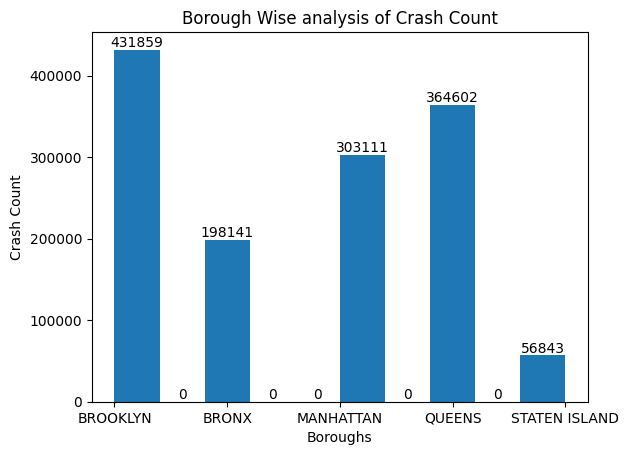

In [12]:
counts, edges, bars = plt.hist(borough_list)
plt.xlabel("Boroughs")
plt.ylabel("Crash Count")
plt.bar_label(bars)
plt.title("Borough Wise analysis of Crash Count")

Most crashes happened in Brooklyn, whereas Staten Island was the safest among them.

One analysis could what kind of vehicles are involved in those crashes.

# Which vehicle type was involved in most crashes

In [47]:
vehicle_code_combined = df.select(F.col('VEHICLE TYPE CODE 1').alias('vehicle_codes')).\
                              union(df.select(F.col('VEHICLE TYPE CODE 2').alias('vehicle_codes'))).
                              groupby('vehicle_codes').count().sort(F.col('count'), ascending=False)

In [57]:
vehicle_code_data = vehicle_code_combined.collect()
vehicle_code_data = [[ind['vehicle_codes'], ind['count']] for ind in vehicle_code_data]

In [141]:
# Removing empty values
empty_value_list = [None, 'None', 'UNKNOWN', 'OTHER']
vehicle_code_data_filtered = [sublist for sublist in vehicle_code_data if sublist[0] not in empty_value_list]

In [142]:
# Merging values that are the same but written differently
# To later delete duplciates


# Function to merge values
def vehicle_code_merge(vehicle, data):
    vehicle_ele = [vehicle, 0]
    # To store indices of duplicates
    del_inds = []
    for ind, sub_l in enumerate(data):
        if re.search(vehicle, sub_l[0], re.IGNORECASE):
            vehicle_ele[1] += sub_l[1]
            del_inds.append(ind)
    
    data.append(vehicle_ele)
    data = [i for j, i in enumerate(data) if j not in set(del_inds)]
    
    return data

vehicle_code_data_filtered = vehicle_code_merge('Station Wagon', vehicle_code_data_filtered)
vehicle_code_data_filtered = vehicle_code_merge('Sedan', vehicle_code_data_filtered)
vehicle_code_data_filtered = vehicle_code_merge('Taxi', vehicle_code_data_filtered)
vehicle_code_data_filtered = vehicle_code_merge('Bus', vehicle_code_data_filtered)
vehicle_code_data_filtered = vehicle_code_merge('Truck', vehicle_code_data_filtered)
vehicle_code_data_filtered = vehicle_code_merge('Van', vehicle_code_data_filtered)

vehicle_code_data_filtered = sorted(vehicle_code_data_filtered, key=lambda x: x[1], reverse=True)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Station Wagon'),
  Text(1, 0, 'Sedan'),
  Text(2, 0, 'PASSENGER VEHICLE'),
  Text(3, 0, 'Taxi'),
  Text(4, 0, 'Truck')])

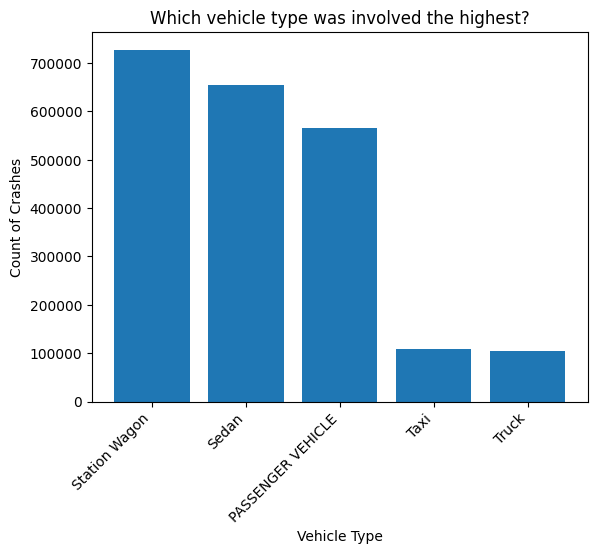

In [159]:
plt.bar(x=[str(i[0]) for i in vehicle_code_data_filtered[:5]], 
        height=[i[1] for i in vehicle_code_data_filtered[:5]])

plt.title("Which vehicle type was involved the highest?")
plt.xlabel("Vehicle Type")
plt.ylabel("Count of Crashes")
plt.xticks(rotation=45, ha='right')

# Deaths occurred within each borough

In [163]:
deaths_borough_data = df.select('NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS KILLED', 
          'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED', 
          'BOROUGH').groupby('BOROUGH').\
          agg(F.sum('NUMBER OF PERSONS KILLED').alias('NUMBER OF PERSONS KILLED'),\
              F.sum('NUMBER OF PEDESTRIANS KILLED').alias('NUMBER OF PEDESTRIANS KILLED'),\
              F.sum('NUMBER OF CYCLIST KILLED').alias('NUMBER OF CYCLIST KILLED'),\
              F.sum('NUMBER OF MOTORIST KILLED').alias('NUMBER OF MOTORIST KILLED'),\
             ).collect()

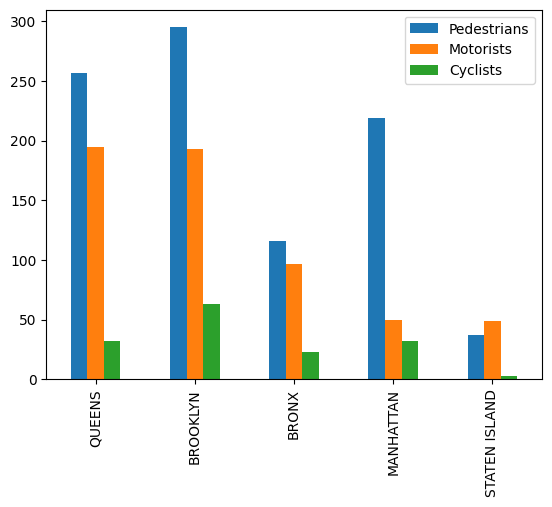

In [172]:
boroughs = [ind['BOROUGH'] for ind in deaths_borough_data]
X = [ind['NUMBER OF PEDESTRIANS KILLED'] for ind in deaths_borough_data]
Y = [ind['NUMBER OF CYCLIST KILLED'] for ind in deaths_borough_data]
Z = [ind['NUMBER OF MOTORIST KILLED'] for ind in deaths_borough_data]

df = pd.DataFrame(np.c_[X,Z, Y], index=boroughs)
df.plot.bar()

plt.legend(["Pedestrians", "Motorists", "Cyclists"])
plt.xlabel("Boroughs")
plt.ylabel("Death Counts")
plt.show()

# Number of collisions for boroughs within each hour of the day